In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

print(sys.path)

['/home/tiendat/transformer-entropy-ids/notebooks', '/home/tiendat/miniconda3/envs/torchtf/lib/python39.zip', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import math
from dataPreprocess import DatasetPreprocess
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import os
import time
import warnings
import torch.nn.functional as F
import time

In [3]:
def draw_confusion(label_y, pre_y, path):
    confusion = confusion_matrix(label_y, pre_y)
    print(confusion)
    return confusion

def write_result(label_y, pre_y, classes_num):
    if classes_num > 2:
        accuracy = accuracy_score(label_y, pre_y)
        macro_precision = precision_score(label_y, pre_y, average='macro')
        macro_recall = recall_score(label_y, pre_y, average='macro')
        macro_f1 = f1_score(label_y, pre_y, average='macro')
        micro_precision = precision_score(label_y, pre_y, average='micro')
        micro_recall = recall_score(label_y, pre_y, average='micro')
        micro_f1 = f1_score(label_y, pre_y, average='micro')
        print('  -- test result: ')
        print('    -- accuracy: ', accuracy)
        print('    -- macro precision: ', macro_precision)
        print('    -- macro recall: ', macro_recall)
        print('    -- macro f1 score: ', macro_f1)
        print('    -- micro precision: ', micro_precision)
        print('    -- micro recall: ', micro_recall)
        print('    -- micro f1 score: ', micro_f1)
        report = classification_report(label_y, pre_y)
        print(report)
    else:
        accuracy = accuracy_score(label_y, pre_y)
        precision = precision_score(label_y, pre_y)
        recall = recall_score(label_y, pre_y)
        f1 = f1_score(label_y, pre_y)
        print('  -- test result: ')
        print('    -- accuracy: ', accuracy)
        print('    -- recall: ', recall)
        print('    -- precision: ', precision)
        print('    -- f1 score: ', f1)
        report = classification_report(label_y, pre_y)
        print(report)

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#================================================================
root_dir = "../road/predict_fab_multi/TFRecord_w15_s15/1/"
window_size = 15
d_model = 12
max_time_position = 10000
gran = 1e-6
log_e = 2
batch_size = 10

train_dataset = DatasetPreprocess(root_dir, window_size, window_size, d_model, max_time_position, gran, log_e, is_train=True)
test_dataset = DatasetPreprocess(root_dir, window_size,window_size, d_model, max_time_position, gran, log_e, is_train=False)


print("TRAIN SIZE:", len(train_dataset), " TEST SIZE:", len(test_dataset), " SIZE:", len(train_dataset)+len(test_dataset), " TRAIN RATIO:", round(len(train_dataset)/(len(train_dataset)+len(test_dataset))*100), "%")

# 2 DataLoader? 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
print('finish load data')

TRAIN SIZE: 84688  TEST SIZE: 21188  SIZE: 105876  TRAIN RATIO: 80 %
finish load data


In [9]:
class Config:
    def __init__(self):
        # self.model_name = 'Transformer_road_mas'
        self.model_name = 'Transformer'
        self.payload_size = 8  #int(math.pow(16, self.slide_window))  # 滑动窗口计数的特征的长度 n-gram?
        self.dout_payload = 8 # 经过DNN后的滑动窗口计数特征的维度 Dimensions of sliding window count features after DNN 8
        self.dout_header  = 4 
        self.d_model = self.dout_payload + self.dout_header # transformer的输入的特征的维度, dnn_out_d + 包头长度 The dimension of the input feature of the transformer, dnn_out_d + header length
        self.pad_size = 15
        self.window_size = 15
        self.max_time_position = 10000
        self.nhead = 6 # ori: 5
        self.num_layers = 5
        self.gran = 1e-6
        self.log_e = 2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.classes_num = 7 #5 for car-hacking 6 for road 
        self.batch_size = 10
        self.epoch_num = 200
        self.lr = 0.0001 #0.00001 learning rate 

        self.root_dir = './road/predict_fab_multi/TFRecord_w15_s15/1/'
        # self.root_dir = './road/predict_mas/TFRecord_w15_s15/4/'
        self.model_save_path = '../model/' + self.model_name + '/'
        if not os.path.exists(self.model_save_path):
            os.mkdir(self.model_save_path)
        self.result_file = '/home/tiendat/transformer-entropy-ids/result/trans8_performance.txt'

        self.isload_model = False  # 是否加载模型继续训练 Whether to load the model and continue training
        self.start_epoch = 24  # 加载的模型的epoch The epoch of the loaded model
        self.model_path = 'model/' + self.model_name + '/' + self.model_name + '_model_' + str(self.start_epoch) + '.pth' 

class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class DNN(nn.Module):
    def __init__(self, d_in, d_out):  # config.payload_size, config.dout_payload
        super(DNN, self).__init__()
        self.l1 = nn.Linear(d_in, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, d_out)

    def forward(self, x):
        #print('x: ', x.cpu().numpy()[0])
        out = F.relu(self.l1(x))
        out = F.relu(self.l2(out))
        out = F.relu(self.l3(out))
        #print('dnn out: ', out.cpu().detach().numpy()[0])
        return out

class Time_Positional_Encoding(nn.Module):
    def __init__(self, embed, max_time_position, device):
        super(Time_Positional_Encoding, self).__init__()
        self.device = device

    def forward(self, x, time_position):
        out = x.permute(1, 0, 2)
        out = out + nn.Parameter(time_position, requires_grad=False).to(self.device)
        out = out.permute(1, 0, 2)
        return out
    
class Autoencoder1D(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Autoencoder1D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return F.relu(x)
    
class TransformerPredictor(nn.Module):
    def __init__(self, config):
        super(TransformerPredictor, self).__init__()
        
        if config.mode == "ae":
            self.payload_ae = Autoencoder1D(config.payload_size, config.dout_payload).to(config.device)
            self.header_ae = Autoencoder1D(4, config.dout_header).to(config.device)
            self.dout_payload = config.dout_payload
            self.dout_header = config.dout_header
        elif config.mode == "dnn":
            self.dnn = DNN(config.payload_size, config.dout_payload).to(config.device)
            self.head_dnn = DNN(4, config.dout_header).to(config.device)
            self.dout_payload = config.dout_payload
            self.dout_header = config.dout_header
        elif config.mode == "cb":
            self.ae = Autoencoder1D(12, config.dout_mess).to(config.device)
            self.dout_mess = config.dout_mess
        
        self.mode = config.mode
        self.pad_size = config.pad_size
        self.tse = config.tse
        if config.tse == True:
            self.position_embedding = Time_Positional_Encoding(config.d_model, config.max_time_position, config.device).to(config.device)
        else:
            self.position_embedding = PositionalEncoding(config.d_model, dropout=0.0, max_len=config.max_time_position).to(config.device)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=config.d_model, nhead=config.nhead).to(config.device)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=config.num_layers).to(config.device)
        self.fc = nn.Linear(config.d_model, config.classes_num).to(config.device)
        print(f"Initial model with mode: {self.mode} \
                TSE: {self.tse}")
        
    def forward(self, header, sl_sum, mask, time_position):
        if self.mode == "ae":
            ae_out = torch.empty((sl_sum.shape[0], self.dout_payload, 0)).to(config.device)
            header_ae_out = torch.empty((header.shape[0], self.dout_header, 0)).to(config.device)
            
            for i in range(self.pad_size):
                tmp = self.payload_ae(sl_sum[:, i, :]).unsqueeze(2)
                ae_out = torch.concat((ae_out, tmp), dim=2)
            ae_out = ae_out.permute(0, 2, 1)
            
            for i in range(self.pad_size):
                tmp = self.header_ae(header[:, i, :]).unsqueeze(2)
                header_ae_out = torch.concat((header_ae_out, tmp), dim=2)
            header_ae_out = header_ae_out.permute(0, 2, 1)
            
            x = torch.concat((header_ae_out, ae_out), dim=2).permute(1, 0, 2)
        elif self.mode == "dnn":
            dnn_out = torch.empty((sl_sum.shape[0], self.dout_payload, 0)).to(config.device)
            head_dnn_out = torch.empty((header.shape[0], self.dout_header, 0)).to(config.device)
            
            for i in range(self.pad_size):
                tmp = self.dnn(sl_sum[:, i, :]).unsqueeze(2)
                dnn_out = torch.concat((dnn_out, tmp), dim=2)
            dnn_out = dnn_out.permute(0, 2, 1)
            
            for i in range(self.pad_size):
                tmp = self.head_dnn(header[:, i, :]).unsqueeze(2)
                head_dnn_out = torch.concat((head_dnn_out, tmp), dim=2)
            head_dnn_out = head_dnn_out.permute(0, 2, 1)  
            x = torch.concat((head_dnn_out, dnn_out), dim=2).permute(1, 0, 2)
        
        elif self.mode == "cb":
            x = torch.concat((header, sl_sum), dim=-1)
            ae_out = torch.empty((x.shape[0], 10, 0)).to(config.device)
            for i in range(self.pad_size):
                tmp = self.ae(x[:, i, :]).unsqueeze(2)
                ae_out = torch.concat((ae_out, tmp), dim=2)
            x = ae_out.permute(2, 0, 1)
        else:
            x = torch.concat((header, sl_sum), dim=-1).permute(1, 0, 2)
        
        if self.tse == True:
            out = self.position_embedding(x, time_position)
        else:
            out = self.position_embedding(x)
        out = self.transformer_encoder(out, src_key_padding_mask=mask)
        out = out.permute(1, 0, 2)
        out = torch.sum(out, 1)
        out = self.fc(out)
        return out
    
config = Config()
model = TransformerPredictor(config)
start_epoch = -1
loss_func = nn.CrossEntropyLoss().to(config.device)
opt = optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = CosineWarmupScheduler(opt, warmup=100, max_iters=2000)

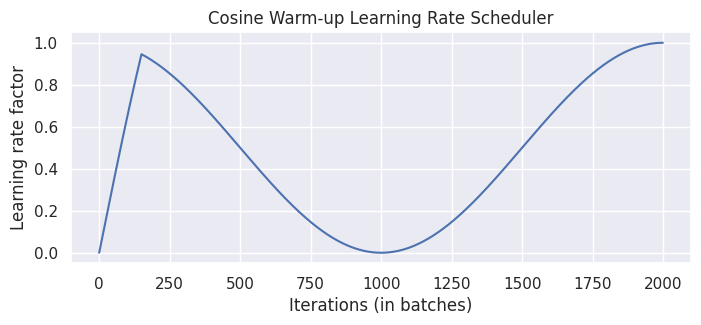

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
sns.reset_orig()

# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-4)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=150, max_iters=1000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [ ]:
for epoch in range(start_epoch + 1, config.epoch_num):
        fin = open(config.result_file, 'a')
        print('--- epoch ', epoch)
        fin.write('-- epoch ' + str(epoch) + '\n')
        for i, sample_batch in enumerate(train_loader):
            batch_header = sample_batch['header'].type(torch.FloatTensor).to(config.device)
            batch_payload = sample_batch['payload'].type(torch.FloatTensor).to(config.device)
            batch_mask = sample_batch['mask'].to(config.device)
            batch_label = sample_batch['label'].to(config.device)
            batch_time_position = sample_batch['time'].to(config.device)
            
            out = model(batch_header, batch_payload, batch_mask, batch_time_position)
            loss = loss_func(out, batch_label)
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()

        # test
        label_y = []
        pre_y = []
        with torch.no_grad():
            for j, test_sample_batch in enumerate(test_loader):
                test_header = test_sample_batch['header'].type(torch.FloatTensor).to(config.device)
                test_payload = test_sample_batch['payload'].type(torch.FloatTensor).to(config.device)
                test_mask = test_sample_batch['mask'].to(config.device)
                test_label = test_sample_batch['label'].to(config.device)
                test_time_position = test_sample_batch['time'].to(config.device)
                
                test_out = model(test_header, test_payload, test_mask, test_time_position)

                pre = torch.max(test_out, 1)[1].cpu().numpy()
                
                pre_y = np.concatenate([pre_y, pre], 0)
                label_y = np.concatenate([label_y, test_label.cpu().numpy()], 0)
            write_result(label_y, pre_y, config.classes_num)
            draw_confusion(label_y, pre_y, '')